In [52]:
import itertools
from hashlib import sha1
from time import time

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy
from matplotlib.image import imread
from scipy import linalg
from scipy.linalg import solve_triangular
from scipy.optimize import minimize
from skimage.transform import resize
from sklearn import linear_model, model_selection
from sklearn.datasets import load_iris
from tqdm import tqdm

# Aula do dia 11/09/2025

## Parte prática de quadrados mínimos

Capítulo 6 do livro _"A First Course in NUMERICAL METHODS"_

Já havia feito essa atividade no arquivo `2025_09_11_least_squares.ipynb`, replicando:

### Hiperparâmetros para geração das matrizes de teste

In [2]:
def generate_random_system(shape: tuple[int, int]):
    n, m = shape
    mat = np.random.randint(-10, 11, shape)
    vec = np.random.randint(-10, 11, n)
    return (mat, vec), {
        "n": n,
        "m": m,
        "matrix_hash": sha1(mat.data).hexdigest(),
        "vector_hash": sha1(vec.data).hexdigest(),
        "type": "Random",
        "rank": np.linalg.matrix_rank(mat),
        "is_square": n == m,
    }

In [3]:
N_FACTORS = [1, 2, 5, 10]
matrix_dict = dict[str, npt.NDArray]()
vector_dict = dict[str, npt.NDArray]()
dataframe_dict_list = list[dict]()

# Matrizes quadradas e depois com proporção 5:3
for f in N_FACTORS:
    n = 5 * f
    m = 5 * f
    ((mat, vec), t_dict) = generate_random_system((n, m))
    matrix_dict[t_dict["matrix_hash"]] = mat
    vector_dict[t_dict["vector_hash"]] = vec
    dataframe_dict_list.append(t_dict)
    # ============================================================
    n = 5 * f
    m = 3 * f
    ((mat, vec), t_dict) = generate_random_system((n, m))
    matrix_dict[t_dict["matrix_hash"]] = mat
    vector_dict[t_dict["vector_hash"]] = vec
    dataframe_dict_list.append(t_dict)

In [4]:
matrices_df = pd.DataFrame(data=dataframe_dict_list)
matrices_df

,n,m,matrix_hash,vector_hash,type,rank,is_square
0,5,5,f933628bd5bdc6a538e6dcb4350fab35d0887b61,daf2723978342a77d4c626a77dd0491677c538e4,Random,5,True
1,5,3,a555cc2ad9a0b492893d9aeb523402e46569515e,f36e40e2a6d1c81c225ded3025d218a69dc15684,Random,3,False
2,10,10,17e9364bb152e8532340b56c6ac622bb7b169256,615b3a4f7f62f045c0a76245e645b1acd4b134c2,Random,10,True
3,10,6,b16a238fb40b4909d34c00eef6fc48884e56bc00,948c9906fcd849b58a61e7b6fa9b9c5ac9c43dd1,Random,6,False
4,25,25,2841ce2aaddb62e179f69d04c51bbd8004922b33,1e89f777e29bd8f8ac6b20f6cdb80f32d854ebe8,Random,25,True
5,25,15,2f53234e85f22d84a23ca1147a25ef13d358845f,a0dc9d45c9e61b90ec2c9caaa9098f7f3824998d,Random,15,False
6,50,50,123fa0eda82d80ec39fcb1ccdb158a0d68c903c1,e35ab6ffd1a06ab58978ad453a590f456f7eabc6,Random,50,True
7,50,30,28bf8fcb0434d9b94b47bdedf767a63c33bb6cc2,09597ef7134128e39087d72b6c5ac8552727ea6e,Random,30,False


### _Normal equations_

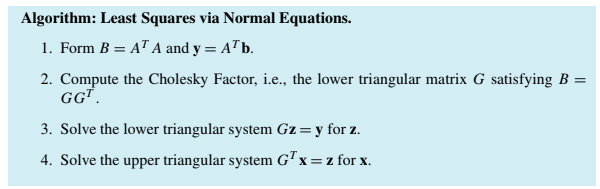

Note que caso a Decomposição Cholesky não seja possível, o método das equações normais não poderá ser utilizado.

In [5]:
def solve_by_normal_eq(matrix_df_row):
    t_start = time()
    A = matrix_dict[matrix_df_row["matrix_hash"]]
    b = vector_dict[matrix_df_row["vector_hash"]]
    B = A.T @ A
    y = A.T @ b
    G = np.linalg.cholesky(B)
    z = solve_triangular(G, y, lower=True)
    x = solve_triangular(G.T, z)
    t_end = time()
    return {
        "resid": np.float64(np.linalg.vector_norm(b - A @ x, ord=2)),
        "time": np.float64((t_end - t_start) * 1000),
    }

In [6]:
normal_eq_dict_list = list[dict]()
for _, row in matrices_df.iterrows():
    normal_eq_dict_list.append(solve_by_normal_eq(row))
normal_eq_df = pd.DataFrame(data=normal_eq_dict_list)
display(pd.concat([matrices_df, normal_eq_df], axis=1))

,n,m,matrix_hash,vector_hash,type,rank,is_square,resid,time
0,5,5,f933628bd5bdc6a538e6dcb4350fab35d0887b61,daf2723978342a77d4c626a77dd0491677c538e4,Random,5,True,4.527201e-13,0.948429
1,5,3,a555cc2ad9a0b492893d9aeb523402e46569515e,f36e40e2a6d1c81c225ded3025d218a69dc15684,Random,3,False,3.693122e+00,0.097990
2,10,10,17e9364bb152e8532340b56c6ac622bb7b169256,615b3a4f7f62f045c0a76245e645b1acd4b134c2,Random,10,True,8.668276e-15,0.070333
3,10,6,b16a238fb40b4909d34c00eef6fc48884e56bc00,948c9906fcd849b58a61e7b6fa9b9c5ac9c43dd1,Random,6,False,1.565664e+01,0.064373
4,25,25,2841ce2aaddb62e179f69d04c51bbd8004922b33,1e89f777e29bd8f8ac6b20f6cdb80f32d854ebe8,Random,25,True,2.494027e-14,0.114679
5,25,15,2f53234e85f22d84a23ca1147a25ef13d358845f,a0dc9d45c9e61b90ec2c9caaa9098f7f3824998d,Random,15,False,2.068753e+01,0.090361
6,50,50,123fa0eda82d80ec39fcb1ccdb158a0d68c903c1,e35ab6ffd1a06ab58978ad453a590f456f7eabc6,Random,50,True,6.809385e-13,0.215054
7,50,30,28bf8fcb0434d9b94b47bdedf767a63c33bb6cc2,09597ef7134128e39087d72b6c5ac8552727ea6e,Random,30,False,2.429147e+01,0.095606


Nota-se que em matrizes não-quadradas, o método possui um um resíduo múltiplas ordens de magnitude maior.

### QR decomposition

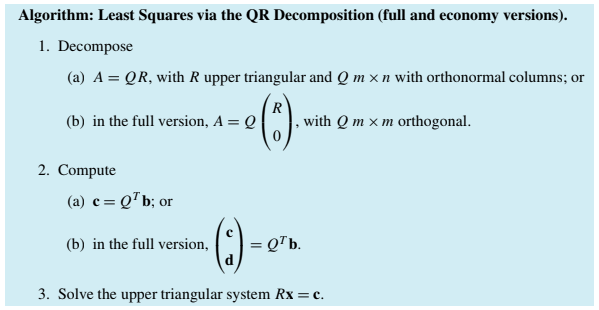

In [7]:
def solve_by_qr(matrix_df_row):
    t_start = time()
    A = matrix_dict[matrix_df_row["matrix_hash"]]
    b = vector_dict[matrix_df_row["vector_hash"]]
    Q, R = np.linalg.qr(A)  # Reduced QR by default on Numpy
    c = Q.T @ b
    x = solve_triangular(R, c)
    t_end = time()
    return {
        "resid": np.float64(np.linalg.vector_norm(b - A @ x, ord=2)),
        "time": np.float64((t_end - t_start) * 1000),
    }

In [8]:
qr_decomp_dict_list = list[dict]()
for _, row in matrices_df.iterrows():
    qr_decomp_dict_list.append(solve_by_qr(row))
qr_decomp_df = pd.DataFrame(data=qr_decomp_dict_list)
display(pd.concat([matrices_df, qr_decomp_df], axis=1))

,n,m,matrix_hash,vector_hash,type,rank,is_square,resid,time
0,5,5,f933628bd5bdc6a538e6dcb4350fab35d0887b61,daf2723978342a77d4c626a77dd0491677c538e4,Random,5,True,2.784691e-14,0.263453
1,5,3,a555cc2ad9a0b492893d9aeb523402e46569515e,f36e40e2a6d1c81c225ded3025d218a69dc15684,Random,3,False,3.693122e+00,0.095606
2,10,10,17e9364bb152e8532340b56c6ac622bb7b169256,615b3a4f7f62f045c0a76245e645b1acd4b134c2,Random,10,True,7.283605e-15,0.095129
3,10,6,b16a238fb40b4909d34c00eef6fc48884e56bc00,948c9906fcd849b58a61e7b6fa9b9c5ac9c43dd1,Random,6,False,1.565664e+01,0.085592
4,25,25,2841ce2aaddb62e179f69d04c51bbd8004922b33,1e89f777e29bd8f8ac6b20f6cdb80f32d854ebe8,Random,25,True,1.242074e-14,0.230312
5,25,15,2f53234e85f22d84a23ca1147a25ef13d358845f,a0dc9d45c9e61b90ec2c9caaa9098f7f3824998d,Random,15,False,2.068753e+01,0.146389
6,50,50,123fa0eda82d80ec39fcb1ccdb158a0d68c903c1,e35ab6ffd1a06ab58978ad453a590f456f7eabc6,Random,50,True,1.690617e-13,0.249863
7,50,30,28bf8fcb0434d9b94b47bdedf767a63c33bb6cc2,09597ef7134128e39087d72b6c5ac8552727ea6e,Random,30,False,2.429147e+01,0.273228


Observa-se o mesmo padrão de erro

### SVD decomposition

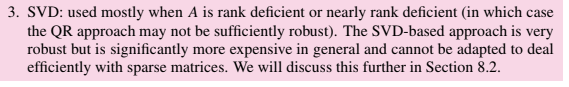

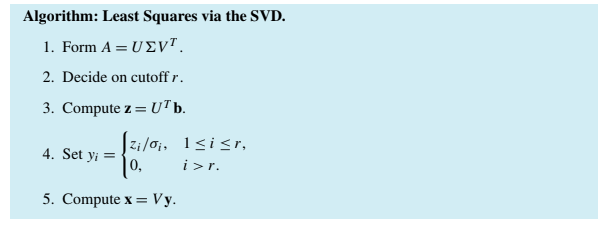

In [9]:
def solve_by_svd(matrix_df_row, r: int):
    t_start = time()
    A = matrix_dict[matrix_df_row["matrix_hash"]]
    b = vector_dict[matrix_df_row["vector_hash"]]
    U, S, Vt = np.linalg.svd(A)
    z = U.T @ b
    rank = min(r, len(S))
    y = np.zeros(len(S))
    y[:rank] = z[:rank] / S[:rank]
    x = Vt.T @ y
    t_end = time()
    return {
        "resid": np.float64(np.linalg.vector_norm(b - A @ x, ord=2)),
        "time": np.float64((t_end - t_start) * 1000),
    }

In [10]:
svd_decomp_dict_list = list[dict]()
for _, row in matrices_df.iterrows():
    svd_decomp_dict_list.append(solve_by_svd(row, row["m"]))
svd_decomp_df = pd.DataFrame(data=svd_decomp_dict_list)
display(pd.concat([matrices_df, svd_decomp_df], axis=1))

,n,m,matrix_hash,vector_hash,type,rank,is_square,resid,time
0,5,5,f933628bd5bdc6a538e6dcb4350fab35d0887b61,daf2723978342a77d4c626a77dd0491677c538e4,Random,5,True,3.899902e-14,0.266314
1,5,3,a555cc2ad9a0b492893d9aeb523402e46569515e,f36e40e2a6d1c81c225ded3025d218a69dc15684,Random,3,False,3.693122e+00,0.062466
2,10,10,17e9364bb152e8532340b56c6ac622bb7b169256,615b3a4f7f62f045c0a76245e645b1acd4b134c2,Random,10,True,8.301262e-14,0.056267
3,10,6,b16a238fb40b4909d34c00eef6fc48884e56bc00,948c9906fcd849b58a61e7b6fa9b9c5ac9c43dd1,Random,6,False,1.565664e+01,0.055790
4,25,25,2841ce2aaddb62e179f69d04c51bbd8004922b33,1e89f777e29bd8f8ac6b20f6cdb80f32d854ebe8,Random,25,True,4.229323e-14,0.138521
5,25,15,2f53234e85f22d84a23ca1147a25ef13d358845f,a0dc9d45c9e61b90ec2c9caaa9098f7f3824998d,Random,15,False,2.068753e+01,0.078917
6,50,50,123fa0eda82d80ec39fcb1ccdb158a0d68c903c1,e35ab6ffd1a06ab58978ad453a590f456f7eabc6,Random,50,True,3.371969e-13,2.564907
7,50,30,28bf8fcb0434d9b94b47bdedf767a63c33bb6cc2,09597ef7134128e39087d72b6c5ac8552727ea6e,Random,30,False,2.429147e+01,0.202179


Novamente, observamos uma dificuldade em calcular corretamente sistemas não-quadrados. Foi utilizado como _cut-off_ a quantidade de colunas na matriz original.

## Exemplos da Seção 3.5

Novamente, já havia feito essa atividade no arquivo `2025_09_11_section_3_5.ipynb`, replicando:

In [11]:
x = np.sort(4 * (np.random.rand(25, 1) - 0.5), axis=0)
# Geração sintética com ruído
b = 0.9 * x + 0.1 * np.random.randn(len(x), 1)
atrue = np.linalg.lstsq(x, b, rcond=None)[0]
# Least-squares a
b[-1] = -5.5
acorrupt = np.linalg.lstsq(x, b, rcond=None)[0][0]


# Realizando minimização da norma L1
def L1_norm(a):
    return np.linalg.norm(a * x - b, ord=1)


a0 = acorrupt
res = minimize(L1_norm, a0)
aL1 = res.x[0]

Ao compararmos `aL1` com o coeficiente angular utilizado para gerar os dados (0.9):

$|a_{L1} - 0.9|$

In [12]:
print(np.abs(aL1 - 0.9))

0.004222136254252162


_Feature Selection and LASSO Regression_

In [13]:
A = np.random.randn(100, 10)
x = np.array([0, 0, 1, 0, 0, 0, -1, 0, 0, 0])
b = A @ x + 2 * np.random.randn(100)
xL2 = np.linalg.pinv(A) @ b

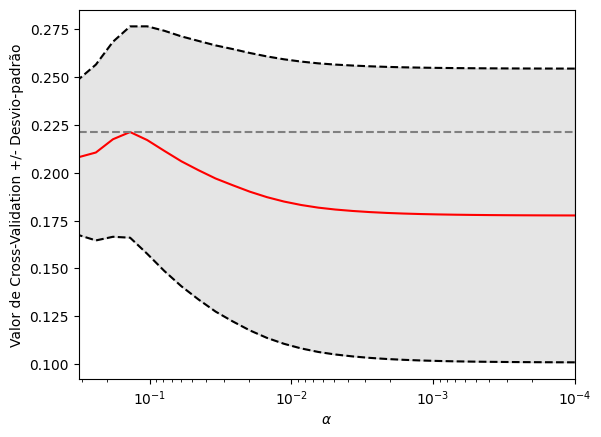

In [14]:
reg = linear_model.LassoCV(cv=10).fit(A, b)
lasso = linear_model.Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{"alpha": alphas}]
clf = model_selection.GridSearchCV(lasso, tuned_parameters, cv=10, refit=False)
clf.fit(A, b)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]
plt.semilogx(alphas, scores, "r-")
std_error = scores_std / np.sqrt(10)
plt.semilogx(alphas, scores + std_error, "k--")
plt.semilogx(alphas, scores - std_error, "k--")
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.1, color="k")
plt.ylabel("Valor de Cross-Validation +/- Desvio-padrão")
plt.xlabel("$\\alpha$")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[-1], alphas[0]])
plt.show()

# Exercícios substituindo aula do dia 18/09/2025

## Conjunto de dados

Foi utilizado o NHTSA FARS, conjunto de dados de acidentes de trânsito nos EUA, disponível em:

https://static.nhtsa.gov/nhtsa/downloads/FARS/2023/National/FARS2023NationalCSV.zip

In [15]:
fars_data = pd.read_csv("../resources/FARS2023NationalCSV/accident.csv")
print("Colunas disponíveis:", fars_data.columns)

Colunas disponíveis: Index(['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL',
       'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT', 'COUNTY', 'COUNTYNAME',
       'CITY', 'CITYNAME', 'MONTH', 'MONTHNAME', 'DAY', 'DAYNAME', 'DAY_WEEK',
       'DAY_WEEKNAME', 'YEAR', 'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME',
       'TWAY_ID', 'TWAY_ID2', 'ROUTE', 'ROUTENAME', 'RUR_URB', 'RUR_URBNAME',
       'FUNC_SYS', 'FUNC_SYSNAME', 'RD_OWNER', 'RD_OWNERNAME', 'NHS',
       'NHSNAME', 'SP_JUR', 'SP_JURNAME', 'MILEPT', 'MILEPTNAME', 'LATITUDE',
       'LATITUDENAME', 'LONGITUD', 'LONGITUDNAME', 'HARM_EV', 'HARM_EVNAME',
       'MAN_COLL', 'MAN_COLLNAME', 'RELJCT1', 'RELJCT1NAME', 'RELJCT2',
       'RELJCT2NAME', 'TYP_INT', 'TYP_INTNAME', 'REL_ROAD', 'REL_ROADNAME',
       'WRK_ZONE', 'WRK_ZONENAME', 'LGT_COND', 'LGT_CONDNAME', 'WEATHER',
       'WEATHERNAME', 'SCH_BUS', 'SCH_BUSNAME', 'RAIL', 'RAILNAME', 'NOT_HOUR',
       'NOT_HOURNAME', 'NOT_MIN', 'NOT_MINNAME', 'ARR_HOUR', 'ARR_HOU

In [16]:
with pd.option_context("display.max_row", None):
    print("Coluna com tipos", fars_data.dtypes)

Coluna com tipos STATE             int64
STATENAME        object
ST_CASE           int64
PEDS              int64
PERNOTMVIT        int64
VE_TOTAL          int64
VE_FORMS          int64
PVH_INVL          int64
PERSONS           int64
PERMVIT           int64
COUNTY            int64
COUNTYNAME       object
CITY              int64
CITYNAME         object
MONTH             int64
MONTHNAME        object
DAY               int64
DAYNAME           int64
DAY_WEEK          int64
DAY_WEEKNAME     object
YEAR              int64
HOUR              int64
HOURNAME         object
MINUTE            int64
MINUTENAME       object
TWAY_ID          object
TWAY_ID2         object
ROUTE             int64
ROUTENAME        object
RUR_URB           int64
RUR_URBNAME      object
FUNC_SYS          int64
FUNC_SYSNAME     object
RD_OWNER          int64
RD_OWNERNAME     object
NHS               int64
NHSNAME          object
SP_JUR            int64
SP_JURNAME       object
MILEPT            int64
MILEPTNAME       object

Identificadores inteiros não podem ser usados diretamente pois irão interpretar valores malores como maior correlação direta/inversa com o objetivo da predição. Como o espaço amostral dessas colunas são muito grandes, vamos evitar usá-los como um todo.

No entanto, boa parte das informações estão presentes nos outros arquivos, que se relacionam com esse a partir de um conjunto de identificadores. Na célula a seguir, faço a leitura de todos os arquivos em um grande JOIN com o DataFrame principal. Isso irá ocasionar o processo de _desnormalização_ do conjunto de dados.

Como é inviável realizar o join de todas as informações nesse DataFrame, selecionei 3 arquivos específicos:
- `vehicle.csv`
- `person.csv`
- `drugs.csv`

In [17]:
selected_files = ["vehicle.csv", "person.csv", "drugs.csv"]

for file_path in selected_files:
    other_df = pd.read_csv(f"../resources/FARS2023NationalCSV/{file_path}")
    has_id = "ST_CASE" in other_df.columns
    if has_id:
        already_present_cols = set(fars_data.columns).intersection(
            set(other_df.columns)
        )
        already_present_cols.remove("ST_CASE")
        other_df = other_df.drop(columns=already_present_cols)
        fars_data = pd.merge(fars_data, other_df, on="ST_CASE", how="left")
    else:
        print(f"Arquivo {file_path} não possui ST_CASE, pulando...")
        continue

C:\Users\gtomi\AppData\Local\Temp\ipykernel_20400\215657590.py:4: DtypeWarning: Columns (53,63,67) have mixed types. Specify dtype option on import or set low_memory=False.
  other_df = pd.read_csv(f"../resources/FARS2023NationalCSV/{file_path}")


In [18]:
fars_data.columns

Index(['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL',
       'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT',
       ...
       'DRUGMETHOD', 'DRUGMETHODNAME', 'DRUGRES', 'DRUGRESNAME', 'DRUGQTY',
       'DRUGQTYNAME', 'DRUGACTQTY', 'DRUGACTQTYNAME', 'DRUGUOM',
       'DRUGUOMNAME'],
      dtype='object', length=349)

Agora temos um total de 349 colunas. Para não fazer o processo de _feature engineering_ em todas elas, selecionei apenas algumas colunas que me pareceram interessantes para o problema de predição:

Presentes no arquivo principal `accident.csv`:

- MONTH
- DAY_WEEK
- HOUR
- FUNC_SYS
- NHS
- TYP_INT
- LGT_COND
- WEATHER
- NUMOCCS

Presentes no arquivo `vehicle.csv`:

- HIT_RUN
- V_CONFIG
- DEFORMED
- DR_DRINK
- PREV_ACC
- ACC_TYPE
- ACC_CONFIG

Presentes no arquivo `person.csv`:
- AGE
- INJ_SEV
- SEAT_POS
- HELM_USE
- HELM_MIS
- AIR_BAG
- EJECTION
- EJ_PATH
- DRINKING

Presentes no arquivo `drugs.csv`:
- DRUGSPEC
- DRUGRES

Variável alvo:
- FATALS

In [19]:
used_columns = [
    "MONTH",
    "DAY_WEEK",
    "HOUR",
    "FUNC_SYS",
    "NHS",
    "TYP_INT",
    "LGT_COND",
    "WEATHER",
    "NUMOCCS",
    "HIT_RUN",
    "V_CONFIG",
    "DEFORMED",
    "DR_DRINK",
    "PREV_ACC",
    "ACC_TYPE",
    "ACC_CONFIG",
    "AGE",
    "INJ_SEV",
    "SEAT_POS",
    "HELM_USE",
    "HELM_MIS",
    "AIR_BAG",
    "EJECTION",
    "EJ_PATH",
    "DRINKING",
    "DRUGSPEC",
    "DRUGRES",
    "FATALS",
]
prepared_data = fars_data[used_columns].copy()
with pd.option_context("display.max_columns", None):
    display(prepared_data.head())

,MONTH,DAY_WEEK,HOUR,FUNC_SYS,NHS,TYP_INT,LGT_COND,WEATHER,NUMOCCS,HIT_RUN,V_CONFIG,DEFORMED,DR_DRINK,PREV_ACC,ACC_TYPE,ACC_CONFIG,AGE,INJ_SEV,SEAT_POS,HELM_USE,HELM_MIS,AIR_BAG,EJECTION,EJ_PATH,DRINKING,DRUGSPEC,DRUGRES,FATALS
0,1,4,22,5,0,1,2,1,1,0,0,6,0,0,2,101,33,4,11,20,7,1,0,0,0,0,0,1
1,3,2,2,7,0,1,2,1,1,0,0,6,1,0,6,102,32,4,11,20,7,1,0,0,1,1,3033,1
2,3,2,2,7,0,1,2,1,1,0,0,6,1,0,6,102,32,4,11,20,7,1,0,0,1,1,3022,1
3,3,2,2,7,0,1,2,1,1,0,0,6,1,0,6,102,32,4,11,20,7,1,0,0,1,1,3053,1
4,3,2,2,7,0,1,2,1,1,0,0,6,1,0,6,102,32,4,11,20,7,1,0,0,1,1,5060,1


Dentre as colunas usadas, não irei aplicar one-hot encoding nas temporais, visto que nesse caso, um número próximo indica proximidade semântica.

Todas as demais variáveis, com exceção da variável `AGE` e `FATALS`, serão transformadas em variáveis categóricas com one-hot encoding.

In [20]:
columns_to_one_hot = used_columns.copy()
columns_to_one_hot.remove("MONTH")
columns_to_one_hot.remove("DAY_WEEK")
columns_to_one_hot.remove("HOUR")
columns_to_one_hot.remove("AGE")
columns_to_one_hot.remove("FATALS")
prepared_data = pd.get_dummies(
    prepared_data, columns=columns_to_one_hot, dummy_na=True, dtype=np.uint8
)

In [21]:
prepared_data

,MONTH,DAY_WEEK,HOUR,AGE,FATALS,FUNC_SYS_1.0,FUNC_SYS_2.0,FUNC_SYS_3.0,FUNC_SYS_4.0,FUNC_SYS_5.0,...,DRUGRES_9030.0,DRUGRES_9031.0,DRUGRES_9032.0,DRUGRES_9035.0,DRUGRES_9995.0,DRUGRES_9996.0,DRUGRES_9997.0,DRUGRES_9998.0,DRUGRES_9999.0,DRUGRES_nan
0,1,4,22,33,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,2,2,32,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,2,32,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,2,32,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2,2,32,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122625,12,6,8,38,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1122626,12,6,8,38,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1122627,12,6,8,38,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1122628,12,1,15,47,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Comparando desempenho do LASSO com mínimos quadrados.
X = prepared_data.drop(columns=["FATALS"]).to_numpy()
y = prepared_data["FATALS"].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

lasso_model = linear_model.LassoCV(cv=5, random_state=0, max_iter=10000)
lasso_model.fit(X_train, y_train)
print("Melhor alpha encontrado:", lasso_model.alpha_)
print("Coeficientes do modelo LASSO:", lasso_model.coef_)

lstq_model = linear_model.LinearRegression()
lstq_model.fit(X_train, y_train)
print("Coeficientes do modelo de Mínimos Quadrados:", lstq_model.coef_)

# Comparação de erros (MSE)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_lstq = lstq_model.predict(X_test)
mse_lasso = np.mean((y_test - y_pred_lasso) ** 2)
mse_lstq = np.mean((y_test - y_pred_lstq) ** 2)

Melhor alpha encontrado: 0.009381276567521604
Coeficientes do modelo LASSO: [-1.41017395e-02 -1.36430820e-02 -3.55435703e-03 -4.62186940e-04
  1.03609828e-01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  4.45914658e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.08173631e-02
 -0.00000000e+00  1.85858922e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  3.81789507e-01  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.80119004e-

In [23]:
print(f"MSE do LASSO: {mse_lasso}")
print(f"MSE do Mínimos Quadrados: {mse_lstq}")

MSE do LASSO: 0.5145096597885038
MSE do Mínimos Quadrados: 0.44105525032543164


Apesar do erro superior do método LASSO, nota-se que a maior parte dos coeficientes foi zerado:

In [24]:
total_lasso = len(lasso_model.coef_)
nz_lasso = np.count_nonzero(lasso_model.coef_)
nz_lstq = np.count_nonzero(lstq_model.coef_)
print(f"Número total de coeficientes: {total_lasso}")
print(f"Número de coeficientes não nulos no LASSO: {nz_lasso}")
print(f"Número de coeficientes não nulos no Mínimos Quadrados: {nz_lstq}")

Número total de coeficientes: 634
Número de coeficientes não nulos no LASSO: 27
Número de coeficientes não nulos no Mínimos Quadrados: 632


Por essa razão, o LASSO pode ser interessante para seleção de variáveis, mesmo que o erro seja maior.

# Aula do dia 25/09/2025

## Exercícios práticos

- Seção 3.3: _Compressed Sensing Examples_
- Seção 3.6: _Sparse Representation_
- Seção 3.8: _Sparse Sensor Placement_

### 3.3 _Compressed Sensing Examples_

Eu já havia feito (partes) (d)isso no arquivo "2025_09_25_compressed_sensing.ipynb", então, só irei replicar.

In [25]:
# Solve y = Theta * s for "s"
n = 1000  # dimension of s
p = 200  # number of measurements, dim(y)
Theta = np.random.randn(p, n)
y = np.random.randn(p)

In [26]:
l1_norm = lambda x: np.linalg.norm(x, ord=1)

In [27]:
constr = {"type": "eq", "fun": lambda x: Theta @ x - y}
s_l2 = np.linalg.pinv(Theta) @ y
x0 = np.random.rand(*s_l2.shape)
res = minimize(l1_norm, x0, method="SLSQP", constraints=constr)
s_l1 = res.x

In [28]:
res

     message: Iteration limit reached
     success: False
      status: 9
         fun: 12.07799677753585
           x: [-6.482e-04 -3.378e-02 ...  4.546e-04 -1.396e-03]
         nit: 100
         jac: [-1.000e+00 -1.000e+00 ...  1.000e+00 -1.000e+00]
        nfev: 101435
        njev: 101
 multipliers: [-3.621e-02  1.118e-01 ... -1.568e-03 -1.500e-02]

Como o método não converge (o que é esperado), aplicamos um _threshold_ para calcular a esparsidade da matriz resultante.

In [29]:
THRESHOLDS = [
    1.0e-5,
    5.0e-5,
    1.0e-4,
    5.0e-4,
    1.0e-3,
    5.0e-3,
    1.0e-2,
    5.0e-2,
]

In [30]:
for t in THRESHOLDS:
    s_l1_thresholded = s_l1.copy()
    s_l1_thresholded[np.abs(s_l1_thresholded) <= t] = 0.0
    total_elem = s_l1_thresholded.size
    nz_elem = np.count_nonzero(s_l1_thresholded)
    z_elem = total_elem - nz_elem
    sp = z_elem / total_elem
    print(f"Threshold = {t}")
    print(f"Elementos zerados: {nz_elem}; Esparsidade: {sp * 100:.2f}%")

Threshold = 1e-05
Elementos zerados: 996; Esparsidade: 0.40%
Threshold = 5e-05
Elementos zerados: 967; Esparsidade: 3.30%
Threshold = 0.0001
Elementos zerados: 944; Esparsidade: 5.60%
Threshold = 0.0005
Elementos zerados: 755; Esparsidade: 24.50%
Threshold = 0.001
Elementos zerados: 627; Esparsidade: 37.30%
Threshold = 0.005
Elementos zerados: 385; Esparsidade: 61.50%
Threshold = 0.01
Elementos zerados: 285; Esparsidade: 71.50%
Threshold = 0.05
Elementos zerados: 62; Esparsidade: 93.80%


### 3.6 _Sparse Representation_

In [31]:
mustache = imread("../resources/mustache.jpg")
# Média dos canais RGB para conversão em monocromático
mustache = np.mean(mustache, -1)
# Normalização para [0, 1]. Isso é possível pois a imagem original é binarizada.
mustache = (mustache / 255).astype(int)
mustache = mustache.T

# Dados de todos os rostos
mat = scipy.io.loadmat("../resources/allFaces.mat")
X = mat["faces"]
# Conversão de dimensões
nfaces = mat["nfaces"].reshape(-1)
n = int(mat["n"][0, 0])
m = int(mat["m"][0, 0])

In [32]:
# Separação entre dados de treino e teste
train_size = 30
test_size = 20
people_count = 20
train_set = np.zeros((X.shape[0], train_size * people_count))
test_set = np.zeros((X.shape[0], test_size * people_count))

for person_idx in range(people_count):
    base_idx = 0
    if person_idx > 0:
        base_idx = np.sum(nfaces[:person_idx])
    inds = range(base_idx, base_idx + nfaces[person_idx])
    train_set[:, person_idx * train_size : (person_idx + 1) * train_size] = X[
        :, inds[:train_size]
    ]
    test_set[:, person_idx * test_size : (person_idx + 1) * test_size] = X[
        :, inds[train_size : (train_size + test_size)]
    ]

In [33]:
# É necessário reduzir o tamanho das imagens para que Theta seja subdeterminado
M = train_set.shape[1]

Theta = np.zeros((120, M))
for person_idx in range(M):
    reshaped = np.reshape(np.copy(train_set[:, person_idx]), (m, n))
    downsized = resize(reshaped, (10, 12), anti_aliasing=True)
    Theta[:, person_idx] = np.reshape(downsized, (120,))

In [34]:
# Normalizando cada coluna de Theta de forma que representem um vetor unitário
norms_theta = np.zeros(M)
# O valor é armazenado para reescalamento posteriormente
for person_idx in range(M):
    norms_theta[person_idx] = np.linalg.norm(Theta[:, person_idx])
    Theta[:, person_idx] = Theta[:, person_idx] / norms_theta[person_idx]

In [35]:
x1 = np.copy(test_set[:, 125])
# Modificando imagem de teste para incluir o bigode
x2 = np.copy(x1) * mustache.reshape(n * m)
random_vector = np.random.permutation(n * m)
first30 = random_vector[: int(np.floor(0.3 * len(random_vector)))]
vals30 = (255 * np.random.rand(*first30.shape)).astype(int)
x3 = np.copy(x1)
x3[first30] = vals30
# Aplicação de ruido gaussiano
x4 = np.copy(x1) + 50 * np.random.randn(*x1.shape)

In [36]:
# Realizando downsample das imagens de teste, da mesma forma que foi feito com a família Theta
X = np.zeros((x1.shape[0], 4))
X[:, 0] = x1
X[:, 1] = x2
X[:, 2] = x3
X[:, 3] = x4

Y = np.zeros((120, 4))
for person_idx in range(4):
    tmp = np.reshape(np.copy(X[:, person_idx]), (m, n))
    tmp_small = resize(tmp, (10, 12), anti_aliasing=True)
    Y[:, person_idx] = np.reshape(tmp_small, (120,))

In [37]:
# Busca pela solução esparsa
y1 = np.copy(Y[:, 0])
eps = 0.01


# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = {"type": "ineq", "fun": lambda x: eps - np.linalg.norm(Theta @ x - y1, 2)}
x0 = np.linalg.pinv(Theta) @ y1  # initialize with L2 solution
res = minimize(L1_norm, x0, method="SLSQP", constraints=constr)
s1 = res.x

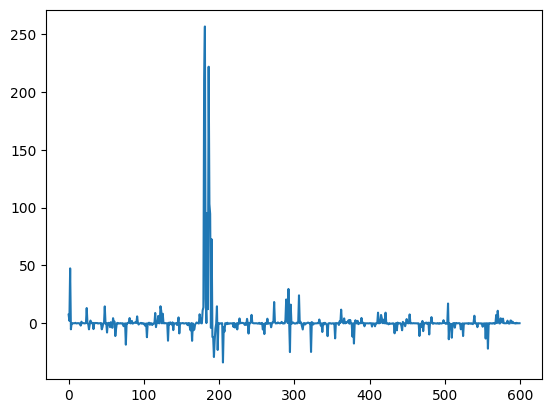

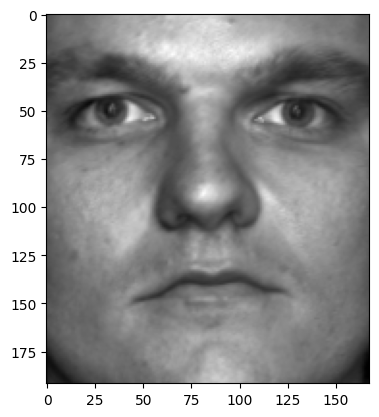

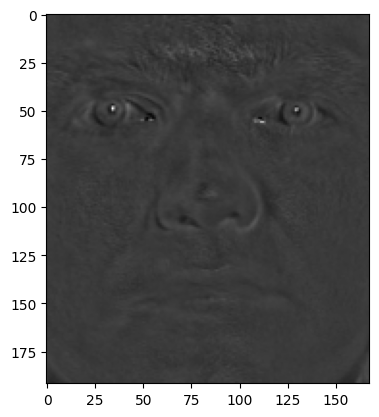

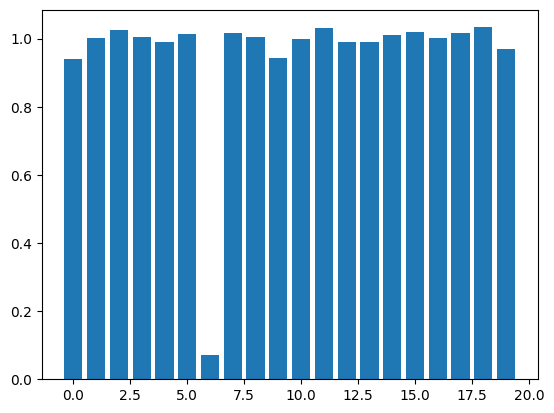

In [38]:
plt.figure()
plt.plot(s1)
plt.figure()
plt.imshow(np.reshape(train_set @ (s1 / norms_theta), (m, n)).T, cmap="gray")
plt.figure()
plt.imshow(np.reshape(x1 - train_set @ (s1 / norms_theta), (m, n)).T, cmap="gray")

binErr = np.zeros(people_count)
for person_idx in range(people_count):
    L = range(person_idx * train_size, (person_idx + 1) * train_size)
    binErr[person_idx] = np.linalg.norm(
        x1 - train_set[:, L] @ (s1[L] / norms_theta[L])
    ) / np.linalg.norm(x1)

plt.figure()
plt.bar(range(people_count), binErr)
plt.show()


In [39]:
# Busca esparsa, com presença do bigode
y2 = np.copy(Y[:, 1])
eps = 500


def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = {"type": "ineq", "fun": lambda x: eps - np.linalg.norm(Theta @ x - y2, 2)}
x0 = np.linalg.pinv(Theta) @ y2  # initialize with L2 solution
res = minimize(L1_norm, x0, method="SLSQP", constraints=constr)
s2 = res.x

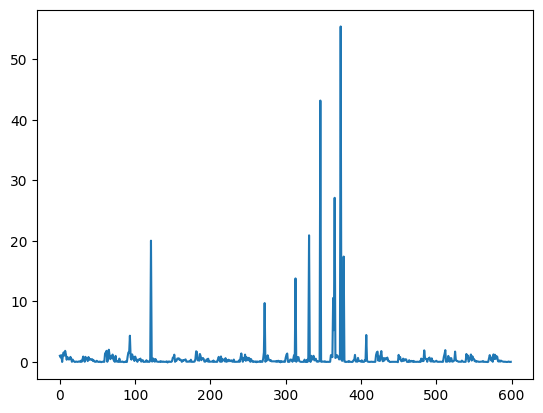

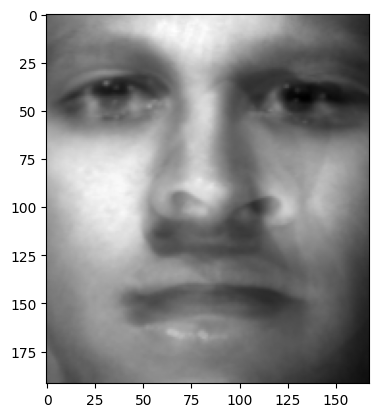

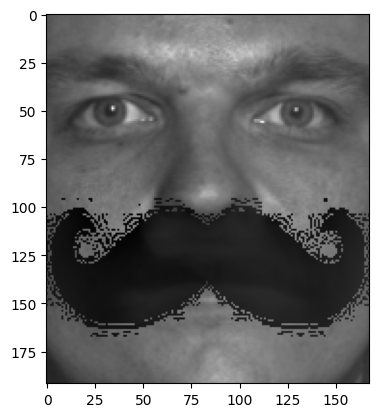

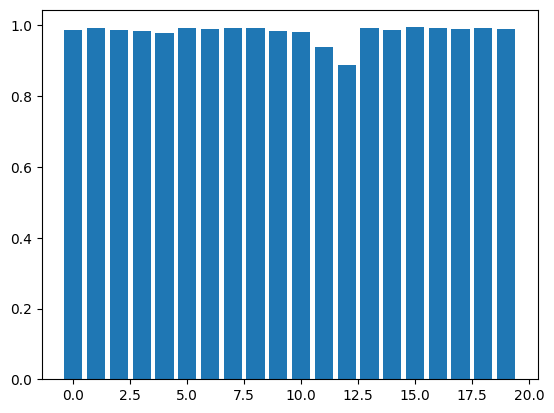

In [40]:
plt.figure()
plt.plot(s2)
plt.figure()
plt.imshow(np.reshape(train_set @ (s2 / norms_theta), (m, n)).T, cmap="gray")
plt.figure()
plt.imshow(np.reshape(x2 - train_set @ (s2 / norms_theta), (m, n)).T, cmap="gray")

binErr = np.zeros(people_count)
for person_idx in range(people_count):
    L = range(person_idx * train_size, (person_idx + 1) * train_size)
    binErr[person_idx] = np.linalg.norm(
        x2 - train_set[:, L] @ (s2[L] / norms_theta[L])
    ) / np.linalg.norm(x2)

plt.figure()
plt.bar(range(people_count), binErr)
plt.show()

In [41]:
# Busca esparsa, com 30% da imagem com oclusão
y3 = np.copy(Y[:, 2])
eps = 1000


# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = {"type": "ineq", "fun": lambda x: eps - np.linalg.norm(Theta @ x - y3, 2)}
x0 = np.linalg.pinv(Theta) @ y3  # initialize with L2 solution
res = minimize(L1_norm, x0, method="SLSQP", constraints=constr)
s3 = res.x

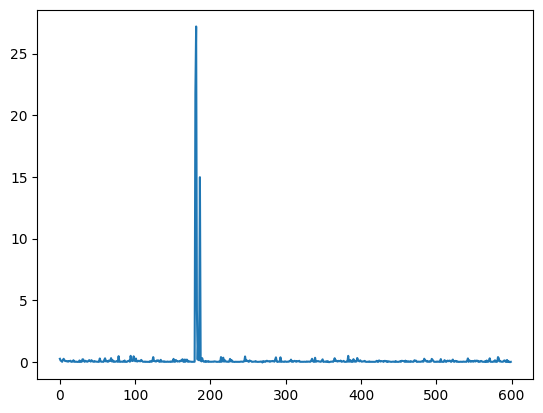

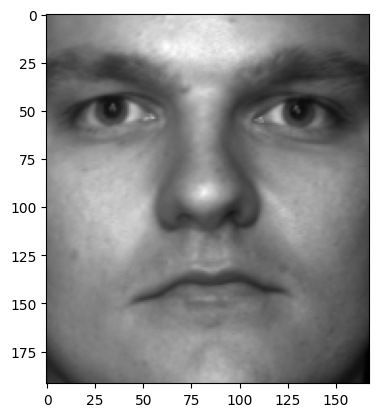

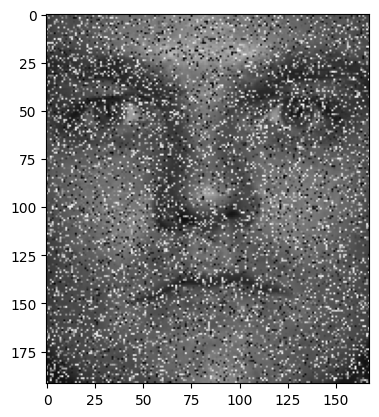

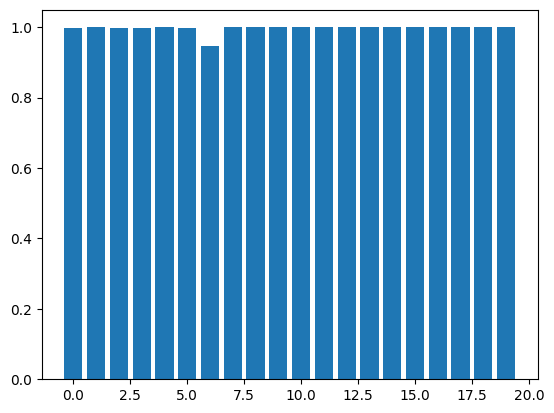

In [42]:
plt.figure()
plt.plot(s3)
plt.figure()
plt.imshow(np.reshape(train_set @ (s3 / norms_theta), (m, n)).T, cmap="gray")
plt.figure()
plt.imshow(np.reshape(x3 - train_set @ (s3 / norms_theta), (m, n)).T, cmap="gray")

binErr = np.zeros(people_count)
for person_idx in range(people_count):
    L = range(person_idx * train_size, (person_idx + 1) * train_size)
    binErr[person_idx] = np.linalg.norm(
        x3 - train_set[:, L] @ (s3[L] / norms_theta[L])
    ) / np.linalg.norm(x3)

plt.figure()
plt.bar(range(people_count), binErr)
plt.show()

In [43]:
# Busca esparsa, com ruido gaussiano
y4 = np.copy(Y[:, 3])
eps = 10


def L1_norm(x):
    return np.linalg.norm(x, ord=1)


constr = {"type": "ineq", "fun": lambda x: eps - np.linalg.norm(Theta @ x - y4, 2)}
x0 = np.linalg.pinv(Theta) @ y4  # initialize with L2 solution
res = minimize(L1_norm, x0, method="SLSQP", constraints=constr)
s4 = res.x

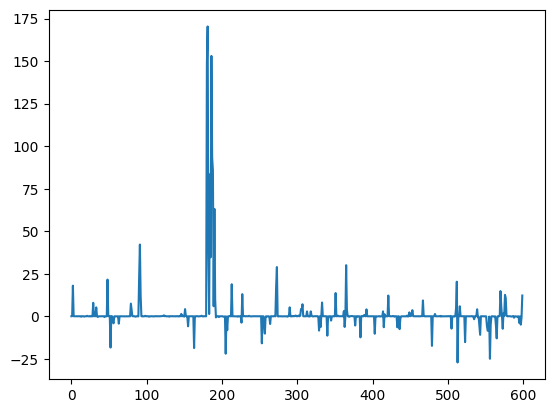

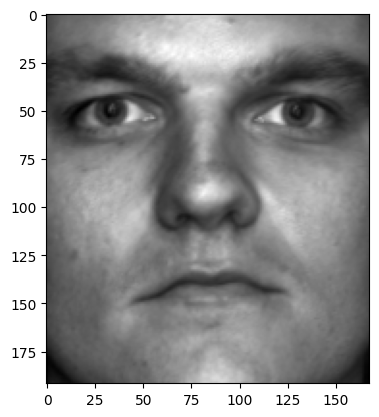

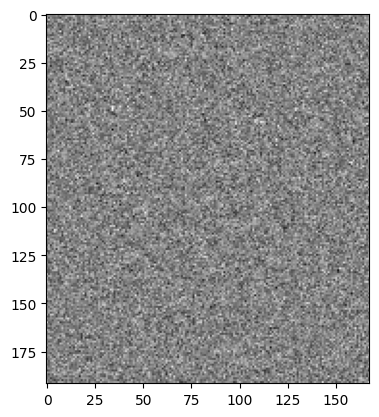

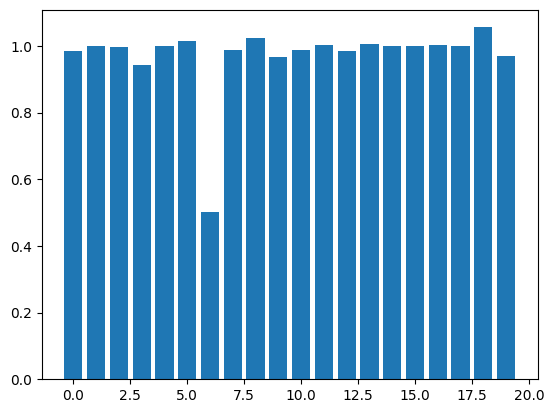

In [44]:
plt.figure()
plt.plot(s4)
plt.figure()
plt.imshow(np.reshape(train_set @ (s4 / norms_theta), (m, n)).T, cmap="gray")
plt.figure()
plt.imshow(np.reshape(x4 - train_set @ (s4 / norms_theta), (m, n)).T, cmap="gray")

binErr = np.zeros(people_count)
for person_idx in range(people_count):
    L = range(person_idx * train_size, (person_idx + 1) * train_size)
    binErr[person_idx] = np.linalg.norm(
        x4 - train_set[:, L] @ (s4[L] / norms_theta[L])
    ) / np.linalg.norm(x4)

plt.figure()
plt.bar(range(people_count), binErr)
plt.show()

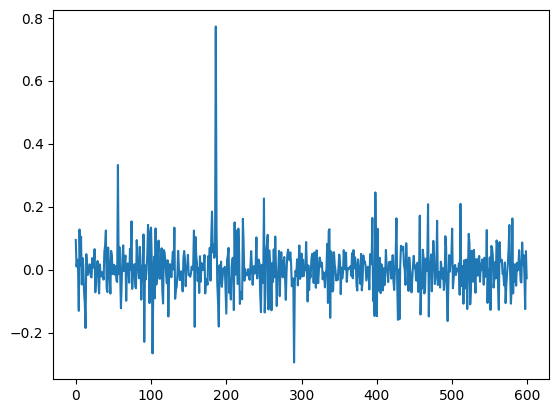

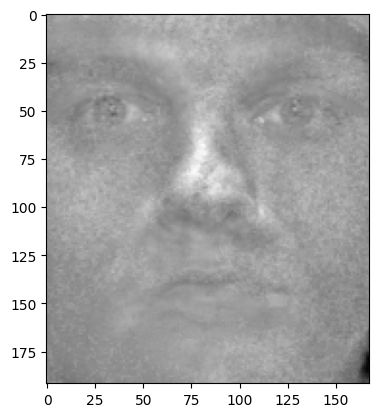

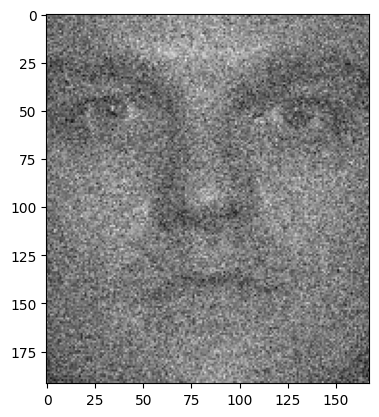

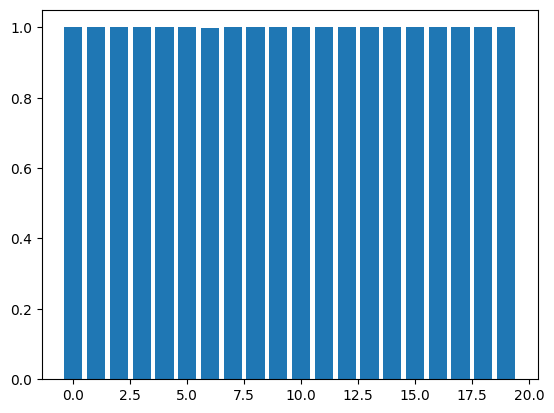

In [45]:
# Demonstração da ineficácia da utilização de mínimos quadrados para o problema
s4L2 = np.linalg.pinv(train_set) @ x4
plt.figure()
plt.plot(s4L2)
plt.figure()
plt.imshow(np.reshape(train_set @ (s4L2 / norms_theta), (m, n)).T, cmap="gray")
plt.figure()
plt.imshow(np.reshape(x4 - train_set @ (s4L2 / norms_theta), (m, n)).T, cmap="gray")

binErr = np.zeros(people_count)
for person_idx in range(people_count):
    L = range(person_idx * train_size, (person_idx + 1) * train_size)
    binErr[person_idx] = np.linalg.norm(
        x4 - train_set[:, L] @ (s4L2[L] / norms_theta[L])
    ) / np.linalg.norm(x4)

plt.figure()
plt.bar(range(people_count), binErr)
plt.show()

### 3.8 _Sparse Sensor Placement_

In [ ]:
faces = mat["faces"]

r = 100
U, S, Vt = np.linalg.svd(faces)
Psi_r = U[:, :r]
Q, R, pivot = linalg.qr(Psi_r.T, pivoting=True)
C = np.zeros_like(Psi_r.T)
C[pivot[:r]] = 1
for k in tqdm(range(r)):
    C[k,pivot[k]] = 1

In [ ]:
Theta = np.dot(C , Psi_r)
y = faces[pivot[:r]]
a = np.dot(np.linalg.pinv(Theta),y)
face_recon = np.dot(Psi_r , a)

# Aula do dia 02/10/2025

## Preenchimento matricial de dados faltantes

Utilizar um dataset como referência, criar uma matriz 20x30 com 30% de entradas ausentes.
Posteriormente, reconstrua e calcule o RMSE.

## Exercício de exploração

Comparação de reconstrução quando 10%, 30% e 50% dos dados estão faltando.

## Estudo do experimento numérico de artigo

Artigo: https://sites.uclouvain.be/absil/2018-03/release_FINAL424_mathbbm2MATHDS.pdf

Utilizar o _dataset_ presente em na Seção _B. Graph learning and regularized matrix completion_

In [46]:
# Para facilitar, vou utilizar o dataset de Iris, clássico em Machine Learning
# Ignorando os labels, utilizando apenas os dados numéricos para aplicação do algoritmo de reconstrução
iris_numeric_data = load_iris()["data"]

Vamos evitar que os dados faltantes impactem a mesma linha, visto que o problema é mal condicionado quando a quantidade de dados faltantes para uma amostra é maior do que a metade das suas características.

In [47]:
# Fatores para exploração (% de dados faltantes)
missing_data_factors = [0.1, 0.3, 0.5]
transformed_data: dict[float, np.ndarray] = {}
for factor in missing_data_factors:
    data_missing = iris_numeric_data.copy()
    # Escolhendo índices aleatórios para definir como NaN
    n_samples, n_features = data_missing.shape
    n_samples_missing = int(n_samples * n_features * factor)
    missing_indices = np.random.permutation(n_samples)[:n_samples_missing]
    for index in missing_indices:
        col_missing = np.random.randint(0, n_features)
        data_missing[index, col_missing] = np.nan
    transformed_data[factor] = data_missing

Para garantir que a lógica de corrompimento dos dados funcionou:

In [48]:
for person_idx, td in transformed_data.items():
    n_nans = np.isnan(td).sum()
    total_elements = td.size
    print(
        f"{person_idx * 100}% faltantes\n",
        f"\nNúmero de NaNs: {n_nans} de {total_elements} elementos\n",
    )

10.0% faltantes
 
Número de NaNs: 60 de 600 elementos

30.0% faltantes
 
Número de NaNs: 150 de 600 elementos

50.0% faltantes
 
Número de NaNs: 150 de 600 elementos



Verificando se alguma linha possui 2 ou mais faltantes:

In [49]:
for person_idx, td in transformed_data.items():
    n_rows_with_2_or_more_nans = sum(np.isnan(row).sum() >= 2 for row in td)
    print(
        f"{person_idx * 100}% faltantes\n",
        f"Número de linhas com 2 ou mais NaNs: {n_rows_with_2_or_more_nans} de {td.shape[0]} linhas\n",
    )

10.0% faltantes
 Número de linhas com 2 ou mais NaNs: 0 de 150 linhas

30.0% faltantes
 Número de linhas com 2 ou mais NaNs: 0 de 150 linhas

50.0% faltantes
 Número de linhas com 2 ou mais NaNs: 0 de 150 linhas



In [50]:
# Como forma de testar diferentes abordagens na reconstrução de matrizes com dados faltantes, vamos aplicar 2 métodos distintos:
# 1. Decomposição SVD: a partir de uma matriz reconstruída com posto reduzido, de forma que os dados faltantes sejam interpolados
# 2. Mínimos quadrados alternados: dado X = UVt, é feito um processo onde U é fixo e V é otimizado, e depois V é fixo e U é otimizado, iterativamente, até convergência
def svd_reconstruction(
    incomplete_data: np.ndarray, rank: int, n_iters: int = 500, tol: float = 1.0e-3
) -> np.ndarray:
    nan_mask = np.isnan(incomplete_data)
    # O algoritmo SVD não pode ser aplicado a matrizes com NaNs. Vamos preencher esses valores com a média da respectiva coluna.
    data_filled = np.where(
        np.isnan(incomplete_data), np.nanmean(incomplete_data, axis=0), incomplete_data
    )
    for it in range(n_iters):
        old_data_filled = data_filled.copy()
        U, S, VT = np.linalg.svd(data_filled, full_matrices=False)
        S_reduced = np.zeros((rank, rank))
        np.fill_diagonal(S_reduced, S[:rank])
        reconstructed = U[:, :rank] @ S_reduced @ VT[:rank, :]
        data_filled[nan_mask] = reconstructed[nan_mask]
        diff = np.linalg.norm(data_filled - old_data_filled, ord="fro")
        print(f"[SVD]: Iter={it}, Diff: {diff}")
        if diff < tol:
            break
    return data_filled


def alternating_lq(
    incomplete_data: np.ndarray, rank: int, n_iters: int = 500, tol: float = 1.0e-3
) -> np.ndarray:
    n_samples, n_features = incomplete_data.shape
    # Inicialização de U e V usando SVD na matriz preenchida
    data_filled = np.where(
        np.isnan(incomplete_data), np.nanmean(incomplete_data, axis=0), incomplete_data
    )
    U0, S0, VT0 = np.linalg.svd(data_filled, full_matrices=False)
    U = U0[:, :rank] * np.sqrt(S0[:rank])
    V = VT0[:rank, :].T * np.sqrt(S0[:rank])
    mask = ~np.isnan(incomplete_data)
    for it in range(n_iters):
        prev_U = U.copy()
        prev_V = V.copy()
        # Atualizar V fixando U
        for j in range(n_features):
            V[j, :] = np.linalg.lstsq(
                U[mask[:, j]], incomplete_data[mask[:, j], j], rcond=None
            )[0]
        # Atualizar U fixando V
        for i in range(n_samples):
            U[i, :] = np.linalg.lstsq(
                V[mask[i, :]], incomplete_data[i, mask[i, :]], rcond=None
            )[0]
        diff_U = np.linalg.norm(U - prev_U, ord="fro")
        diff_V = np.linalg.norm(V - prev_V, ord="fro")
        print(f"[ALQ]: Iter={it}, Diff U: {diff_U}, Diff V: {diff_V}")
        if np.allclose(U, prev_U, rtol=tol) and np.allclose(V, prev_V, rtol=tol):
            break
    reconstructed = U @ V.T
    return reconstructed


# Métrica RMSE
# Nesse caso, o caso controle é a matriz completamente preenchida, o que não é caso realista
# A máscara permite comparar apenas os valores que foram originalmente removidos
def rmse(original: np.ndarray, reconstructed: np.ndarray, mask: np.ndarray) -> float:
    return np.sqrt(np.mean(np.power((original[mask] - reconstructed[mask]), 2)))

In [53]:
# Como o posto da matriz original é 4, podemos testar a reconstrução com posto de 1 até 4 e ver o resultado obtido
# Fazemos isso para cada um dos métodos, e cada um dos fatores de dados faltantes
# Para facilitar visualização e comparação, visualização será feita via DataFrame
reduced_ranks = range(1, 5)
iterator = itertools.product(reduced_ranks, transformed_data.items())
rows = {
    "Posto": [],
    "Fator de dados faltantes": [],
    "RMSE[SVD]": [],
    "RMSE[Alternating LQ]": [],
}
for rr, (factor, incomplete_data) in iterator:
    # Localização dos dados conhecidos
    known = ~np.isnan(incomplete_data)
    # E desconhecidos
    unknown = np.isnan(incomplete_data)
    svd_reconstructed = svd_reconstruction(incomplete_data, rank=rr)
    alt_lq_reconstructed = alternating_lq(incomplete_data, rank=rr)
    # Após reconstruir, substituímos os dados conhecidos pelos originais, para evitar distorções em dados já conhecidos.
    svd_reconstructed[known] = iris_numeric_data[known]
    alt_lq_reconstructed[known] = iris_numeric_data[known]
    # O RMSE é calculado apenas nos dados que eram originalmente desconhecidos
    svd_rmse = rmse(iris_numeric_data, svd_reconstructed, unknown)
    alt_lq_rmse = rmse(iris_numeric_data, alt_lq_reconstructed, unknown)
    rows["Posto"].append(rr)
    rows["Fator de dados faltantes"].append(f"{factor * 100}%")
    rows["RMSE[SVD]"].append(svd_rmse)
    rows["RMSE[Alternating LQ]"].append(alt_lq_rmse)

df = pd.DataFrame(rows)
display(df)

[SVD]: Iter=0, Diff: 4.128254884756514
[SVD]: Iter=1, Diff: 1.5698639749606698
[SVD]: Iter=2, Diff: 0.8268780662062675
[SVD]: Iter=3, Diff: 0.46532713098215556
[SVD]: Iter=4, Diff: 0.2659852821507395
[SVD]: Iter=5, Diff: 0.15293194953635886
[SVD]: Iter=6, Diff: 0.08822632880120523
[SVD]: Iter=7, Diff: 0.05103045733588501
[SVD]: Iter=8, Diff: 0.029586492513680028
[SVD]: Iter=9, Diff: 0.017193923175604024
[SVD]: Iter=10, Diff: 0.01001594895240139
[SVD]: Iter=11, Diff: 0.005848922543538597
[SVD]: Iter=12, Diff: 0.003424206416724352
[SVD]: Iter=13, Diff: 0.0020099007533444465
[SVD]: Iter=14, Diff: 0.0011828864715602851
[SVD]: Iter=15, Diff: 0.0006980376543445522
[ALQ]: Iter=0, Diff U: 0.4772377244073353, Diff V: 0.0401665858234533
[ALQ]: Iter=1, Diff U: 0.009360377359238682, Diff V: 0.03811437958820962
[ALQ]: Iter=2, Diff U: 0.00047032106023347516, Diff V: 0.0018791055642998987
[SVD]: Iter=0, Diff: 6.099209115824373
[SVD]: Iter=1, Diff: 2.528648876002879
[SVD]: Iter=2, Diff: 1.376883426753

,Posto,Fator de dados faltantes,RMSE[SVD],RMSE[Alternating LQ]
0,1,10.0%,0.929793,0.929847
1,1,30.0%,0.977991,0.977993
2,1,50.0%,1.021148,1.021180
3,2,10.0%,0.370248,0.370200
4,2,30.0%,0.323544,0.323701
5,2,50.0%,0.353015,0.352913
6,3,10.0%,0.391740,0.392524
7,3,30.0%,1.069547,1.624440
8,3,50.0%,0.971296,1.030012
9,4,10.0%,0.978622,0.594018


O melhor resultado se dá quando o posto reduzido é exatamente metade do posto total. Os resultados obtidos para ambos os métodos são muito próximos, e nesse caso, o erro não apresenta muito crescimento dado o aumento da quantidade de dados faltantes.